In [1]:
from PIL import Image
import glob
import re
import os
import numpy as np
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
import random
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision import models

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
path = config['data']['potsdam']

### Check Files

In [3]:
image_files = glob.glob(path+'/Patched/*image*.tif')
mask_files = glob.glob(path+'/Patched/*mask*.tif') 

print(f"Found: \t {len(image_files)} Images \n\t {len(mask_files)} Masks")

Found: 	 342 Images 
	 342 Masks


In [4]:
# Get base name of all files and create dict with image and mask file paths
pattern = 'top_potsdam_\d{1,2}_\d{1,2}_patch_\d{1}_\d{1}'
patch_base_names = [re.search(pattern, image_files[i]).group(0) for i in range(len(image_files))]
# Get rid of image 'top_potsdam_4_12 because mask RGB mapping has errors and does not adhere to the mapping convention
patch_base_names = [name for name in patch_base_names if 'potsdam_4_12_' not in name]
# The dictionary is integer-indexed to allow the dataset __getitem__ class to sample using an integer idx
file_paths = {i:(path+'/Patched/'+name+'_image.tif',path+'/Patched/'+name+'_mask.tif') for i, name in enumerate(patch_base_names)}
file_paths[0]

('/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/potsdam/Patched/top_potsdam_2_11_patch_2_2_image.tif',
 '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/potsdam/Patched/top_potsdam_2_11_patch_2_2_mask.tif')

### Utility functions to map from RGB to Label and back

In [5]:
# Define official RGB to Label mappings
RGB_classes = [
       (255, 255, 255), # impervious surfaces
       (0,  0, 255), # building
       (0, 255, 255), # low vegetation
       (0,  255,  0), # tree
       (255, 255, 0), # car
       (255, 0, 0)] # clutter/background
Label_classes = [
        "impervious surfaces",
        "building",
        "low vegetation",
        "tree",
        "car",
        "clutter/background"]

idx2label = {key: value for key, value in enumerate(Label_classes)}

# Create a dictionary to translate a mask to a rgb tensor
idx2rgb = {key: value for key, value in enumerate(RGB_classes)}
rgb2idx = {v: k for k, v in idx2rgb.items()}

# Dict to map from label to rgb
rgb2label = dict(zip(Label_classes, RGB_classes))

In [6]:
def map_rgb2label(mask):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for color, label in rgb2idx.items():
        indices = np.where(np.all(mask == color, axis=-1))
        label_mask[indices] = label
    return label_mask

In [7]:
def map_label2rgb(label_mask):
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype='uint8')
    for i in range(label_mask.shape[0]):
        for j in range(label_mask.shape[1]):
            try:
                rgb[i,j,:] = idx2rgb[label_mask[i,j].item()]
            except:
                rgb[i,j,:] = [0,0,0]
    return rgb

##### Test function

In [8]:
mask = np.array(Image.open(file_paths[10][1]))
label_mask = map_rgb2label(mask)
rgb = map_label2rgb(label_mask)
rgb = ToPILImage()(rgb)

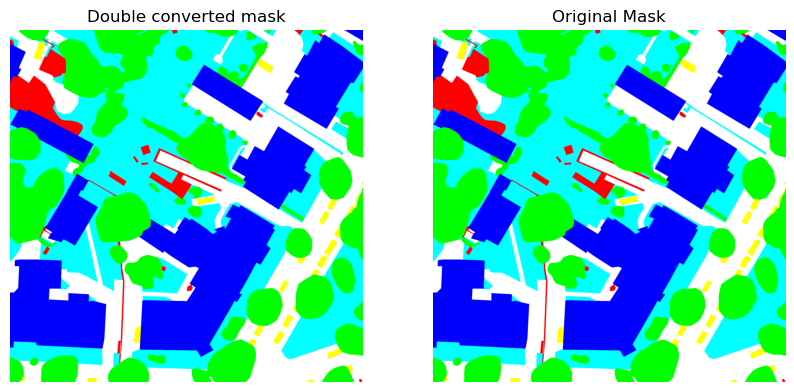

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(rgb)
ax[1].imshow(mask)
ax[0].set_title('Double converted mask')
ax[1].set_title('Original Mask')
ax[0].axis('off'), ax[1].axis('off')
plt.show()

### Create Custom PyTorch Dataset Class for the Potsdam Dataset

In [10]:
class PotsdamDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_filepath = self.file_paths[idx][0]
        mask_filepath = self.file_paths[idx][1]

        image = np.array(Image.open(image_filepath))
        mask = np.array(Image.open(mask_filepath))
        # Convert RGB mask to label mask
        label_mask = map_rgb2label(mask)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=label_mask)
            transformed_image = transformed['image']
            transformed_label_mask = transformed['mask']
            return transformed_image, transformed_label_mask
        else:
            return image, label_mask

#### Test Dataset Class

In [11]:
dataset = PotsdamDataset(file_paths, transform=None)

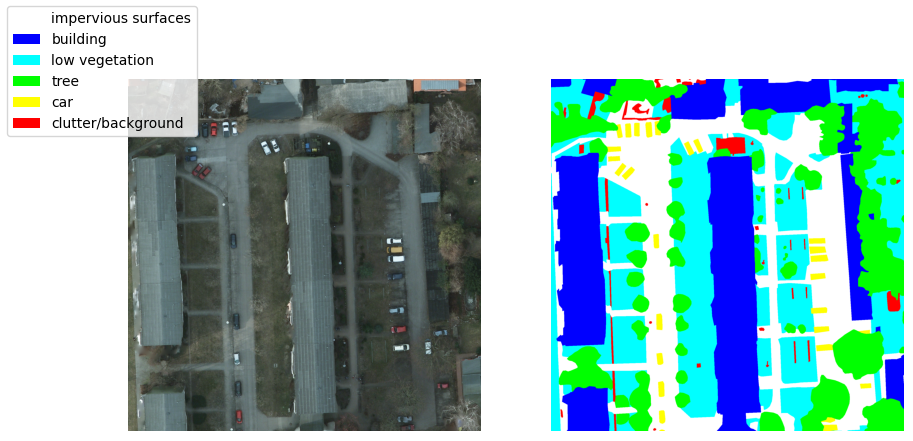

In [12]:
idx = random.randint(0, len(dataset))
fig, ax = plt.subplots(1,2, figsize=(10,5))
data = dataset[idx]
ax[0].imshow(ToPILImage()(data[0]))
ax[1].imshow(ToPILImage()(map_label2rgb(data[1])))

# Extract colors and labels from the dictionary
colors = [(r / 255, g / 255, b / 255, 1) for r, g, b in idx2rgb.values()]
labels = [str(idx2label[key]) for key in idx2rgb]

# Create a legend using the extracted colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
fig.legend(patches, labels, loc='upper left')
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

### Build image transforms and augmentations

In [13]:
# Define transforms to be used in the Training
train_transform = A.Compose(
    [
        A.Resize(height=1000, width=1000),
        A.Flip(p=0.5),
        A.ColorJitter(p=0.25),
        A.Normalize(
            mean = [0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
        A.Resize(height=1000, width=1000),
        A.Normalize(
            mean = [0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ],
)

### Train/Test Split and DataLoader

In [14]:
from sklearn.model_selection import train_test_split

train_keys, test_keys = train_test_split(list(file_paths.keys()), test_size=0.2)
train_dict = {i:file_paths[key] for i,key in enumerate(train_keys)}
test_dict = {i:file_paths[key] for i,key in enumerate(test_keys)}
print(f"Length of all files: {len(file_paths)}")
print(f"Length of train ({len(train_dict)}) and test ({len(test_dict)}): {len(train_dict)+len(test_dict)}")

Length of all files: 333
Length of train (266) and test (67): 333


In [15]:
train_loader = DataLoader(PotsdamDataset(train_dict, transform=train_transform), batch_size=2)
test_loader = DataLoader(PotsdamDataset(test_dict, transform=test_transform), batch_size=2)

##### Test the dataloader with the transforms

In [16]:
for batch_idx, (img, label) in enumerate(train_loader):
    if batch_idx == 1: 
        break
    print(batch_idx, img.shape, label.shape)


0 torch.Size([2, 3, 1000, 1000]) torch.Size([2, 1000, 1000])


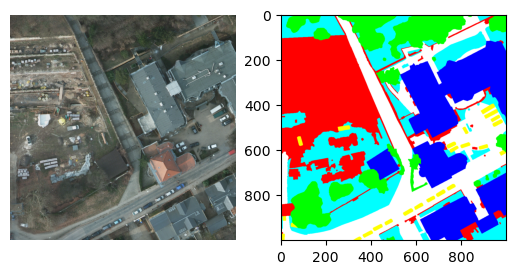

In [17]:
data = next(iter(train_loader))
img = data[0]
label = data[1]
normalized_image_array = np.array(img[0])

# Define the mean and standard deviation values used for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Expand dimensions of mean and std arrays to match the shape of the image array
mean = np.expand_dims(np.expand_dims(mean, axis=1), axis=1)
std = np.expand_dims(np.expand_dims(std, axis=1), axis=1)

# Convert the normalized image array back to the original scale
original_image_array = normalized_image_array * std + mean
original_image_array = np.clip(original_image_array, 0, 1)  # Clip values between 0 and 1

# Transpose the shape of the image array to (1000, 1000, 3) for plotting
original_image_array = np.transpose(original_image_array, (1, 2, 0))

# Extract and reconvert target
target = map_label2rgb(label[0])
target = ToPILImage()(target)

# Plot the original image
fig, ax = plt.subplots(1,2)
ax[0].imshow(original_image_array)
ax[0].axis('off')
ax[1].imshow(target)
plt.show()

### Basic Model

In [ ]:
# Parameters: 
NUM_CLASSES = 6
LR = 1e-4
NUM_EPOCHS = 1

if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else: 
    DEVICE = 'cpu'

NUM_WORKERS = 2

In [ ]:
model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
model.classifier = DeepLabHead(2048, NUM_CLASSES)
model.aux_classifier = None

for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [ ]:
loss_func = nn.CrossEntropyLoss().to(device=DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def calculate_accuracy(test_loader, model, device="cuda"):
  
  count_correct = 0
  total_pixels = 0

  model.eval()
  with torch.no_grad():
    for data, target in tqdm(test_loader):
      data = data.to(device)
      
      # compute probabilities
      probs = torch.nn.Softmax(model(data)['out'])
      # Argmax to get final prediction
      pred = torch.argmax(probs.dim, axis=1).cpu()
      count_correct += (pred == target).sum().item()
      total_pixels += torch.numel(pred)
      print(f"Accuracy: {count_correct/total_pixels}")

In [ ]:
# Training Loop
for epoch in range(NUM_EPOCHS):
    print(f"Start epoch: {epoch+1}")
    
    # Train model
    loss_sum = 0.0

    model.train()
    for batch_idx, (img, label) in enumerate(train_loader):
        
        img = img.to(device=DEVICE)
        label = label.type(torch.LongTensor).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(img)['out']

        loss = loss_func(predictions, label)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Comupte loss sum and count batches
        loss_sum += loss.item()
        batch_idx += 1
        
        if batch_idx%5 == 0:
            print(batch_idx)
        print('Check accuracy')
        calculate_accuracy(test_loader, model, device=DEVICE)
    
    
    # Check accuracy
    #check_accuracy(val_loader, MODEL, pretrained=pre, device=DEVICE)
    
    print(f"End epoch: {epoch+1} \n")